In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import optuna
import functools

from floOTflix.datasets import movielens_get_dataset
from floOTflix.utils import seed
from floOTflix.plots import plot_heatmap
from floOTflix.models import CLIDIOTModel, CLIDIOTGradientModel, MFModel

# Generate dataset

In [14]:
k = 40

seed(0)

(m, n), (X_train, y_train), (X_test, y_test) = movielens_get_dataset("large")

pi_train = torch.zeros(m, n)
pi_train[X_train[:, 0], X_train[:, 1]] = y_train

pi_test = torch.zeros(m, n)
pi_test[X_test[:, 0], X_test[:, 1]] = y_test

pi_sample = pi_train + pi_test

X = torch.cat([X_train, X_test], dim=0)
y = torch.cat([y_train, y_test], dim=0)

plot_heatmap(matrices=[pi_sample, pi_train, pi_test], titles=["$\pi^*$", "$\pi^*_{train}$", "$\pi^*_{test}$"])

KeyboardInterrupt: 

# Solve using CLIDIOT

In [27]:
m, n, k = *pi_sample.shape, A_truth.shape[0]

U = U_truth
V = V_truth

trial = functools.partial(CLIDIOTModel.optuna_trial, m, n, X, y, X_test, y_test, U, V)
study = optuna.create_study(direction='minimize')
# study.optimize(trial, n_trials=100)

[I 2022-10-16 21:34:02,494] A new study created in memory with name: no-name-dae71bbc-d05b-4686-8a76-23602b4eba8a


In [12]:
study.best_params

{'eps': 7.117140576005326,
 'max_clidiot_iter': 313,
 'max_prox_iter': 354,
 'prox_lr': 0.022761152209025193,
 'prox_gamma': 7.97926813515542,
 'prox_reg': 0.2444655698983902,
 'c0': '1e-2',
 'ot_lambda': 7.527066574918035}

/Users/lucasmrdt/.pyenv/versions/3.10.6/lib/python3.10/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Epoch 0, train error: 0.00046119236503727734, test error: 0.0005643533659167588
Epoch 31, train error: 0.00039215729339048266, test error: 0.0004468962433747947
Epoch 62, train error: 0.0003916750429198146, test error: 0.0004465929523576051
Epoch 93, train error: 0.00039152943645603955, test error: 0.00044635249651037157
Epoch 124, train error: 0.0003915216075256467, test error: 0.0004463388177100569
Epoch 155, train error: 0.00039152137469500303, test error: 0.00044633832294493914
Epoch 186, train error: 0.00039152143290266395, test error: 0.0004463383520487696
Epoch 217, train error: 0.00039152137469500303, test error: 0.00044633838115260005
Epoch 248, train error: 0.00039152137469500303, test error: 0.0004463382938411087
Epoch 279, train error: 0.00039152137469500303, test error: 0.00044633832294493914
Epoch 310, train error: 0.0003915214037988335, test error: 0.00044633832294493914


Text(0.5, 0, 'Epoch')

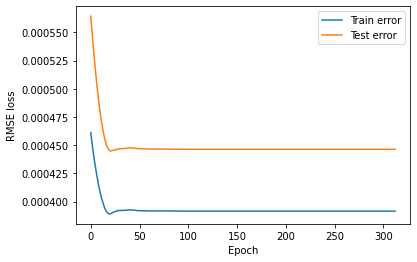

In [38]:
c0 = torch.ones(m, n)
alpha0 = torch.ones(m)
beta0 = torch.ones(n)

best_params = {'eps': 7.117140576005326,
               'max_clidiot_iter': 313,
               'max_prox_iter': 354,
               'prox_lr': 0.022761152209025193,
               'prox_gamma': 7.97926813515542,
               'prox_reg': 0.2444655698983902,
               'c0': '1e-2',
               'ot_lambda': 7.527066574918035}
best_params = {k: v for k, v in best_params.items() if k not in ('c0', 'alpha0', 'beta0')}

model = CLIDIOTModel(m, n, **best_params, c0=c0,
                     alpha0=alpha0, beta0=beta0, verbose=True)
train_errors, test_errors = model.fit(X_train, y_train, X_test, y_test, U, V)

sns.lineplot(x=np.arange(len(train_errors)),
             y=train_errors, label="Train error")
sns.lineplot(x=np.arange(len(test_errors)), y=test_errors, label="Test error")
plt.ylabel("RMSE loss")
plt.xlabel("Epoch")

/Users/lucasmrdt/.pyenv/versions/3.10.6/lib/python3.10/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


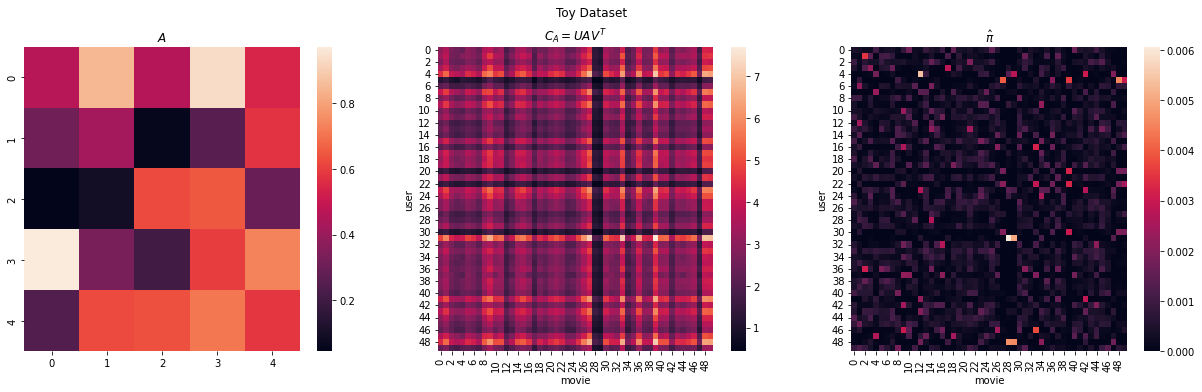

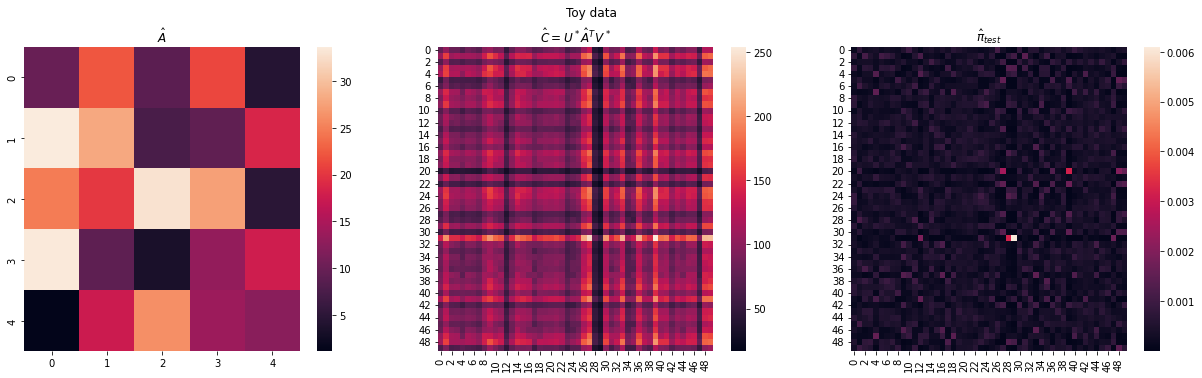

In [54]:
A_hat = model.A
C_hat = U @ A_hat @ V.t()
pi_hat_test = model.ot(c=C_hat)
y_test_pred = model.predict(X_test)

plot_heatmap(matrices=[A_truth, C_truth, pi_sample], titles=["$A$", "$C_A = U A V^T$", "$\hat{\pi}$"], title="Toy Dataset", lambdas=[lambda x: x.set(xlabel=""), lambda x: x.set(xlabel="movie", ylabel="user"), lambda x: x.set(xlabel="movie", ylabel="user")])
plot_heatmap(matrices=[A_hat, C_hat, pi_hat_test], titles=["$\hat{A}$", "$\hat{C} = U^* \hat{A}^T V^*$", "$\hat{\pi}_{test}$"], title="Toy data")

In [64]:
random_indexes = np.random.choice(np.arange(len(y_test)), size=100, replace=False)
y_test_pred_r = y_test_pred[random_indexes]
y_test_r = y_test[random_indexes]

# y_test_pred_normalized = (y_test_pred - y_test_pred.min()) / (y_test_pred.max() - y_test_pred.min())
# y_test_normalized = (y_test - y_test.min()) / (y_test.max() - y_test.min())



# plt.show()
# sns.lineplot(x=range(len(X_test)), y=y_test_pred_normalized, label="prediction")
# sns.lineplot(x=range(len(X_test)), y=y_test_normalized, label="ground truth")
# plt.show()
# sns.lineplot(x=range(len(X_test)), y=np.abs(y_test_pred_normalized - y_test_normalized), label="diff")
# print("AME:", np.abs(y_test_pred_normalized - y_test_normalized).mean())

# The bellowed results show that our model smoothen the ground truth and does not stick presicely to it.

In [61]:
(y_test_pred - y_test).pow(2).mean().sqrt()

tensor(0.0004)

Text(0.5, 1.0, 'Prediction vs ground truth')

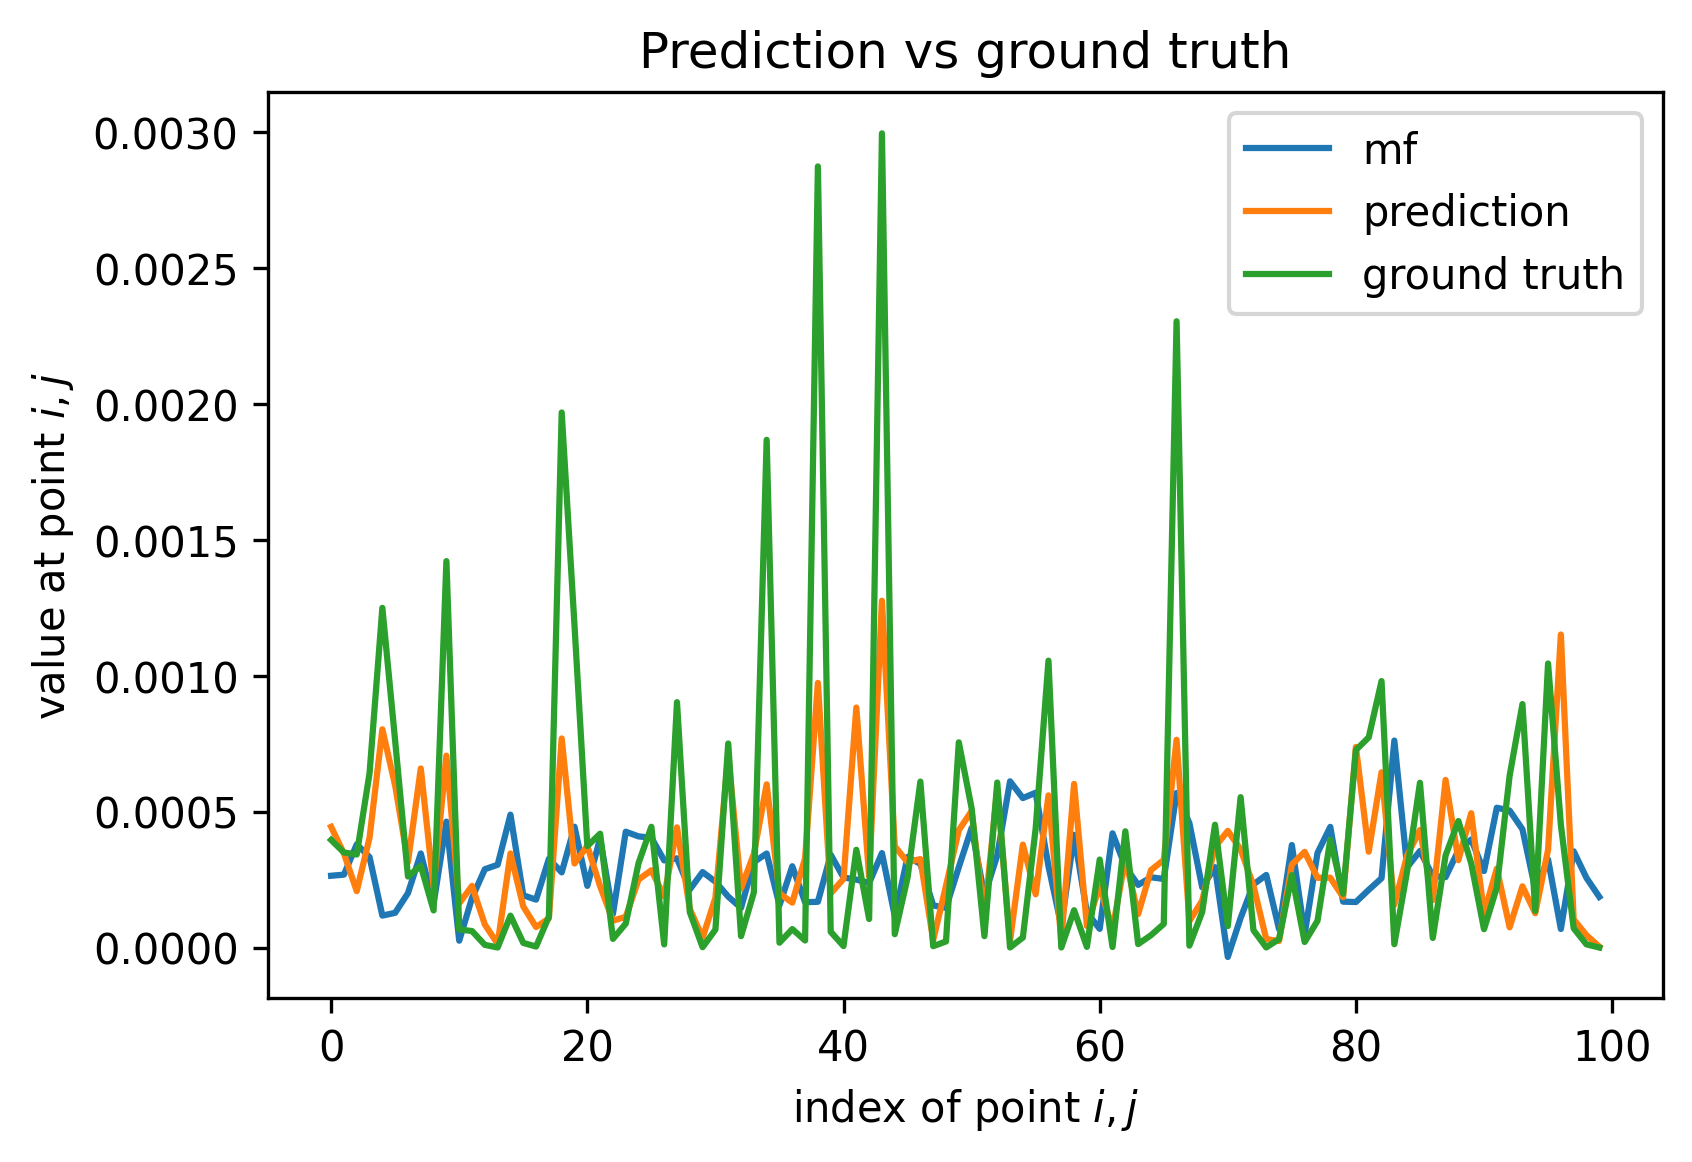

In [81]:
random_indexes = np.random.choice(np.arange(len(y_test)), size=100, replace=False)
y_test_pred_r = y_test_pred[random_indexes]
y_test_r = y_test[random_indexes]
y_random_r = random_pred[random_indexes]
y_mean_r = mean_pred[random_indexes]
y_mf_r = y_pred_mf[random_indexes].detach().numpy()

plt.figure(dpi=300)
# sns.lineplot(x=range(len(random_indexes)), y=y_random_r, label="random")
# sns.lineplot(x=range(len(random_indexes)), y=y_mean_r, label="mean")
sns.lineplot(x=range(len(random_indexes)), y=y_mf_r, label="mf")
sns.lineplot(x=range(len(random_indexes)), y=y_test_pred_r, label="prediction")
sns.lineplot(x=range(len(random_indexes)), y=y_test_r, label="ground truth")
plt.ylabel("value at point $i, j$")
plt.xlabel("index of point $i, j$")
plt.title("Prediction vs ground truth")

In [68]:
random_pred = torch.rand_like(y_test) * y_train.max()
(random_pred - y_test).pow(2).mean().sqrt()

tensor(0.0028)

In [70]:
mean_pred = torch.ones_like(y_test) * y_train.mean()
(mean_pred - y_test).pow(2).mean().sqrt()

tensor(0.0006)

In [80]:
mf_model = MFModel(m, n, k)
mf_model.fit(X_train, y_train, X_test, y_test, n_epochs=100000)

y_pred_mf = mf_model.predict(X_test)
(y_pred_mf - y_test).pow(2).mean().sqrt()

Output()

[23:08:10] Epoch 0, train error: 1.2441977262496948, test error: 1.264621615409851                        ]8;id=421374;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=904339;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

[23:08:13] Epoch 10000, train error: 0.008146521635353565, test error: 0.010958187282085419               ]8;id=236482;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=97993;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

[23:08:17] Epoch 20000, train error: 0.0004907612456008792, test error: 0.0006505330675281584             ]8;id=107006;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=25379;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

[23:08:20] Epoch 30000, train error: 0.0004898206680081785, test error: 0.0006398073164746165             ]8;id=133731;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=543462;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#130\130]8;;\

[23:08:22] Early stopping                                                                                 ]8;id=343891;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py\mf.py]8;;\:]8;id=150816;file:///Users/lucasmrdt/Documents/Dauphine/M2/ML_project/project-recommendation/floOTflix/models/mf.py#125\125]8;;\

tensor(0.0006, grad_fn=<SqrtBackward0>)